## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_vertical_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\segmentAnything\\full\\wavelet\\vertical\\gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


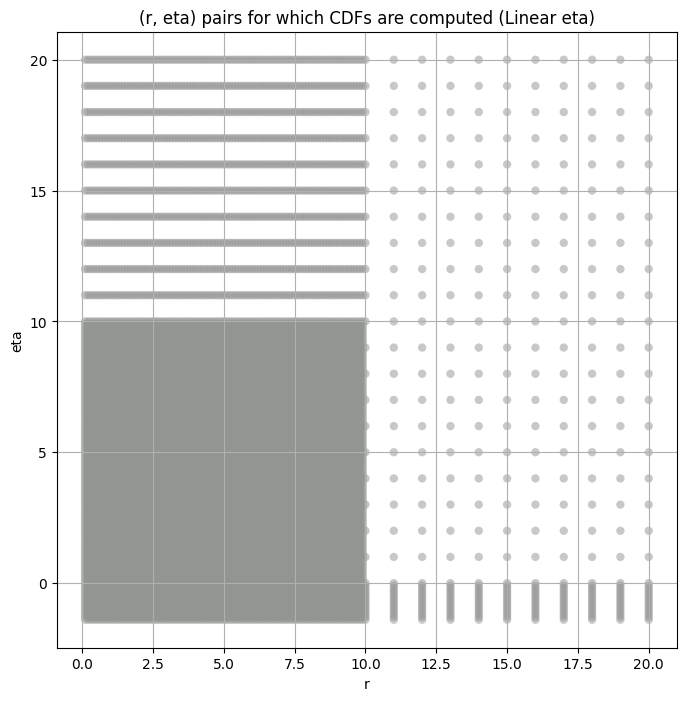

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7896.740000  7319.860000  8503.691000   4.029505    3.282084   
3      2191.322500  2039.346900  2350.041300   5.528359    4.460040   
4       643.439800   592.870900   696.672000   7.709305    6.309804   
5       168.817800   154.845860   183.616710   9.205141    7.572452   
6        41.613914    37.854664    45.583233  11.000242    9.139973   
7         9.721992     8.789999    10.716441  12.992339   10.829866   
8         2.212512     1.985581     2.454784  14.952187   12.354908   
9         0.532969     0.475431     0.594252  16.883390   13.778850   
10        0.144212     0.128029     0.161782  18.381569   14.742287   

       kurt_upper  total_samples  
layer                             
2        4.816091           7072  
3        6.719029          28288  
4        9.355474         113152  
5       11.239720         452608  
6       13.232309        1810432  
7       15.625156        7241728  
8       18.134668       28966912  
9       20.649199      115867648  
10      22.425297      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      7896.740000    7896.740234     6787.275391     6136.387695   
3      2191.322500    2191.322510     2053.996582     1968.641113   
4       643.439800     643.439819      626.170776      613.613281   
5       168.817800     168.817795      163.793182      160.204849   
6        41.613914      41.613914       40.291012       39.314133   
7         9.721992       9.721992        9.384152        9.134138   
8         2.212512       2.212512        2.127515        2.064950   
9         0.532969       0.532969        0.510236        0.493664   
10        0.144212       0.144212        0.137546        0.132603   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5650.150879      5256.560547      4648.382812      4173.654297   
3         1899.365601      1838.977783      1738.515137      1652.977783   
4          602.688049       592.863953       575.496521       560.200256   
5          157.142380       154.387878       149.545120       145.260437   
6           38.474216        37.721745        36.384094        35.212559   
7            8.918615         8.724461         8.381259         8.082151   
8            2.011155         1.963042         1.878547         1.805269   
9            0.479550         0.467026         0.445265         0.426575   
10           0.128429         0.124762         0.118471         0.113154   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          3784.402832      3457.487061      3173.669434      2504.895996  
3          1578.411987      1511.442749      1450.844727      1297.679688  
4           546.502502       534.049500       522.627686       492.744720  
5           141.418747       137.902206       134.647919       126.027908  
6            34.162022        33.204334        32.321724        30.015902  
7             7.814133         7.570000         7.345711         6.762952  
8             1.740051         1.681048         1.627087         1.487870  
9             0.410076         0.395254         0.381778         0.347345  
10            0.108528         0.104425         0.100733         0.091461

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.009867179124547404 7896.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.010580407302258094 6787.2754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.012227888344899407 6136.3877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.017331453305300948 5650.151


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.021621995158843665 5256.5605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.02973058365609893 4648.383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.03801136229195401 4173.6543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.04621841392580639 3784.4028


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.054345217014340474 3457.487


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.06282178024591167 3173.6694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.08123169841932343 2504.896
Number of samples: 7072, Without approximation : 7072


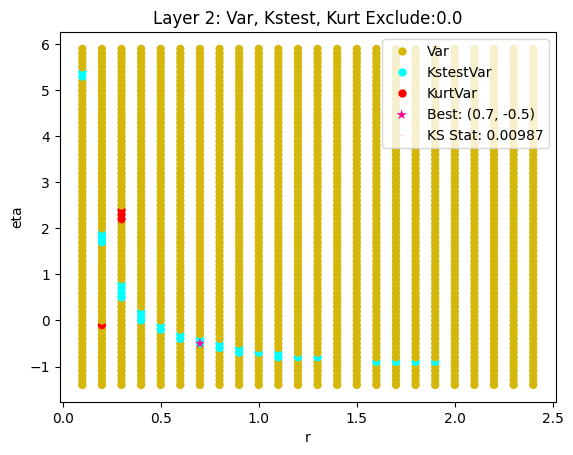

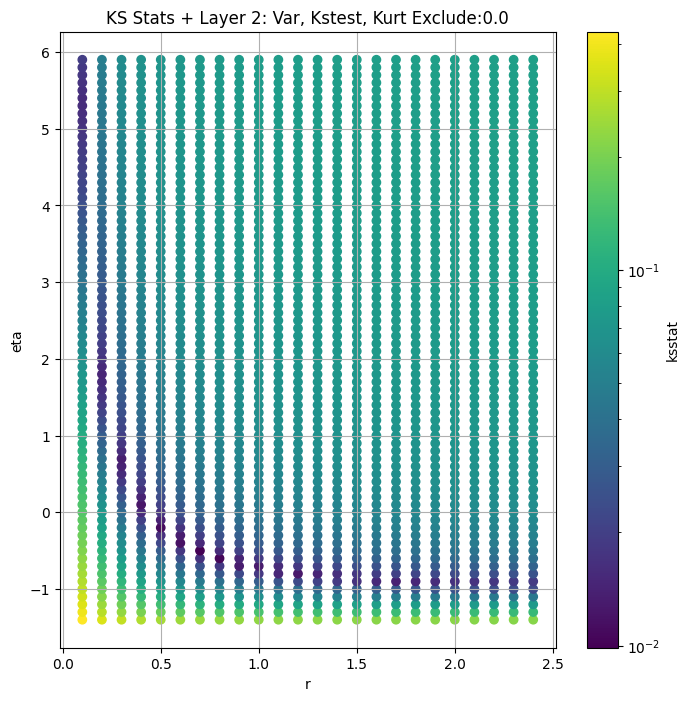

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.004510372556250641 2191.3225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.004569161324860793 2053.9966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.005654156752909034 1968.6411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.00693575953698955 1899.3656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.008049377934079116 1838.9778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.010189684937157217 1738.5151


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.01218256124004713 1652.9778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01414977351901514 1578.412


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.016012841738547667 1511.4427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.018231225038983667 1450.8447


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.024034313661768225 1297.6797
Number of samples: 28288, Without approximation : 28288


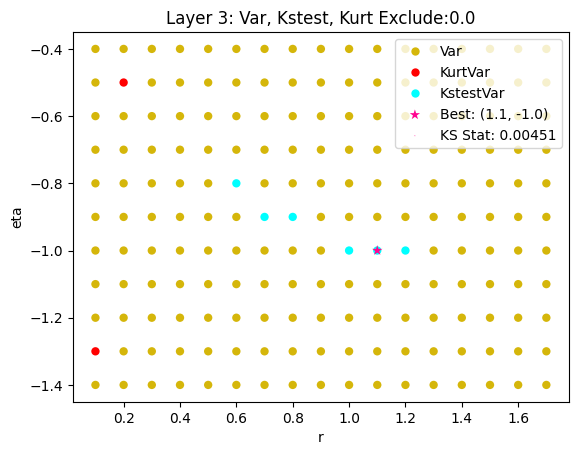

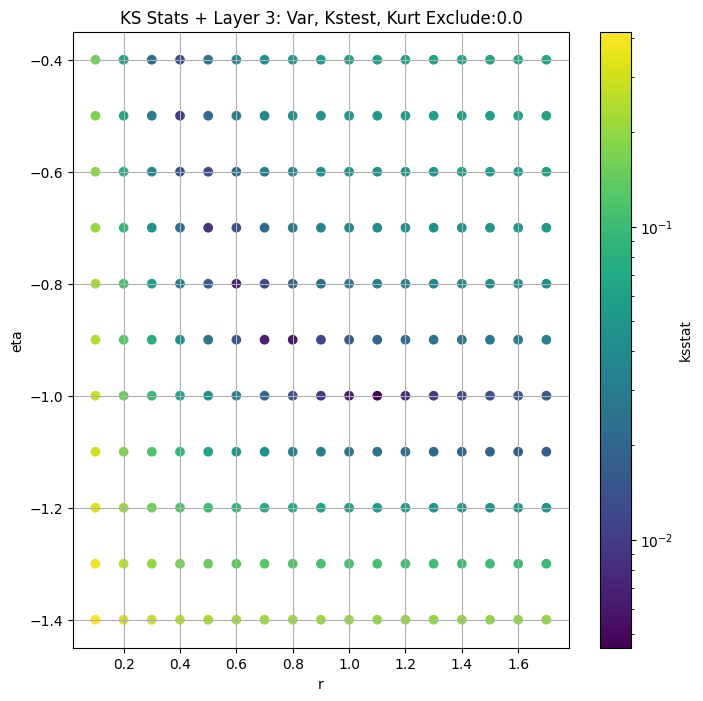

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.005363169559009673 643.4398


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.006570109892196474 626.1708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.005373543900512812 613.6133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.004209753544510586 602.68805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.004529812081050133 592.86395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.00565884795528878 575.4965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.006090701600115725 560.20026


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.006656534394121467 546.5025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.007481137800290902 534.0495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.00798036449016689 522.6277


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.00969923949725571 492.74472
Number of samples: 100000, Without approximation : 113152


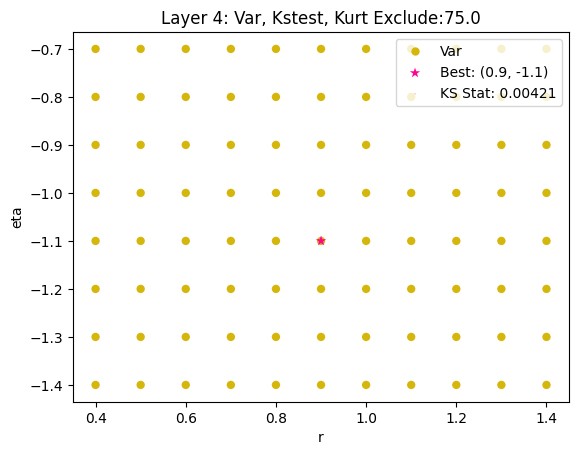

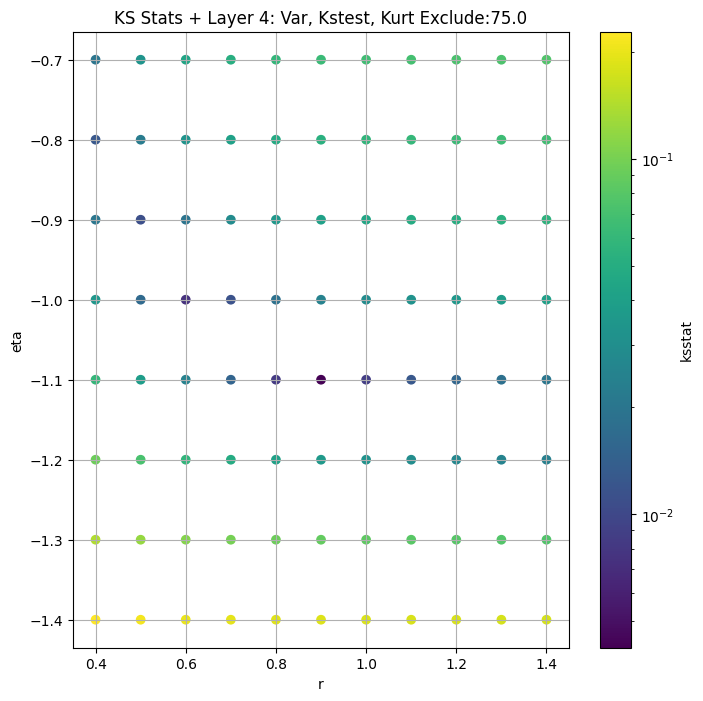

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.00878093102928168 168.8178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.008448433958785362 163.79318


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.008910709158209795 160.20485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.00794522160812805 157.14238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.007920179354263923 154.38788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.007801924724794296 149.54512


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.007818177498657763 145.26044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007199404556082034 141.41875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.007208148376266127 137.9022


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.007346410723590657 134.64792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008908429782127025 126.02791
Number of samples: 100000, Without approximation : 452608


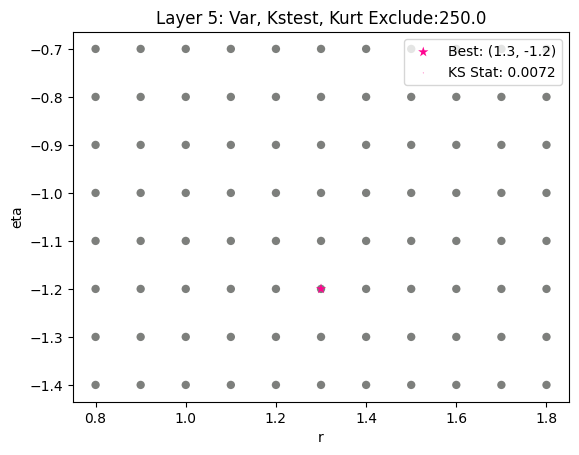

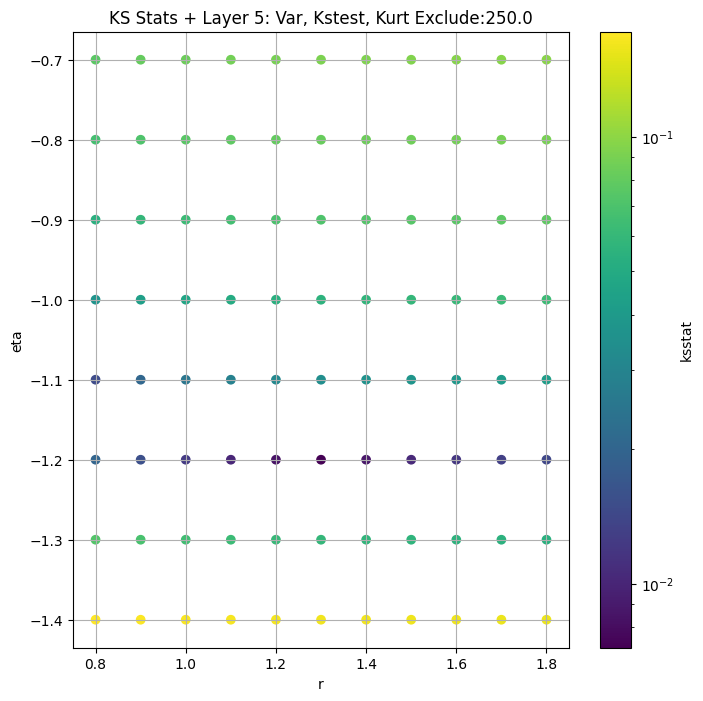

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.017657939525366206 41.613914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.017614062236492867 40.29101


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.017583503939944345 39.314133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.017556309072516596 38.474216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.017531448759040225 37.721745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.017490999768513538 36.384094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.017454258689570623 35.21256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.017419964859060943 34.16202


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.01738729965296304 33.204334


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.01754150154598072 32.321724


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.017576273374438567 30.015902
Number of samples: 100000, Without approximation : 1810432


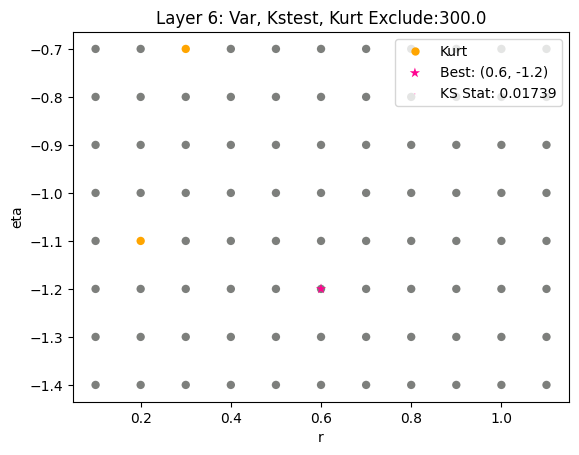

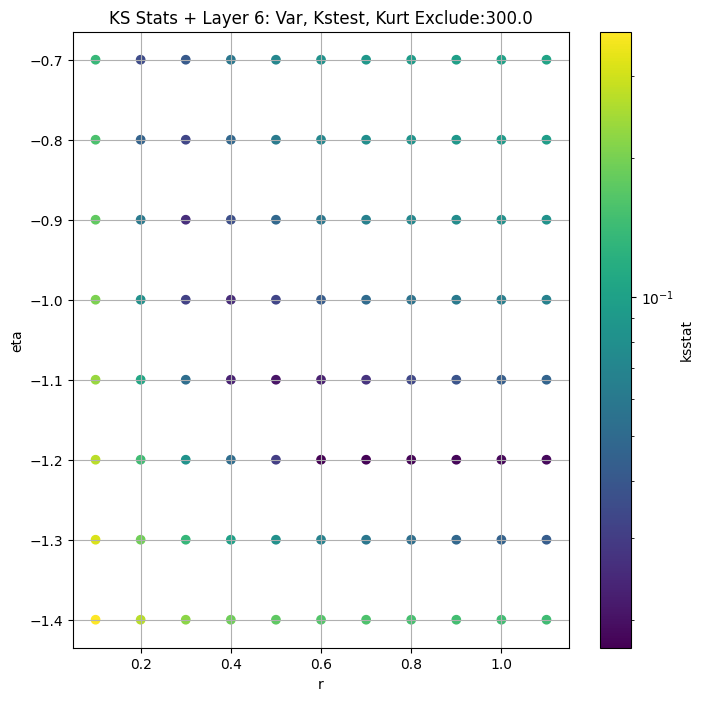

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.039739999999999776 9.721992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.039739999999999776 9.384152


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.039739999999999776 9.134138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.039739999999999776 8.918615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.039739999999999776 8.724461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.039739999999999776 8.381259


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.039739999999999776 8.082151


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.039739999999999776 7.8141327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.039739999999999776 7.57


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.039739999999999776 7.3457108


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.039739999999999776 6.762952
Number of samples: 100000, Without approximation : 7241728


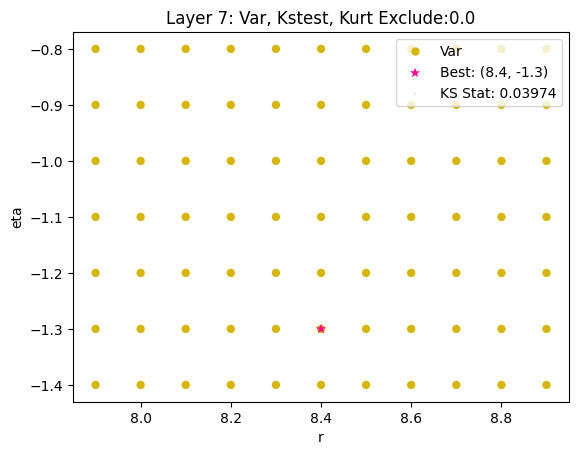

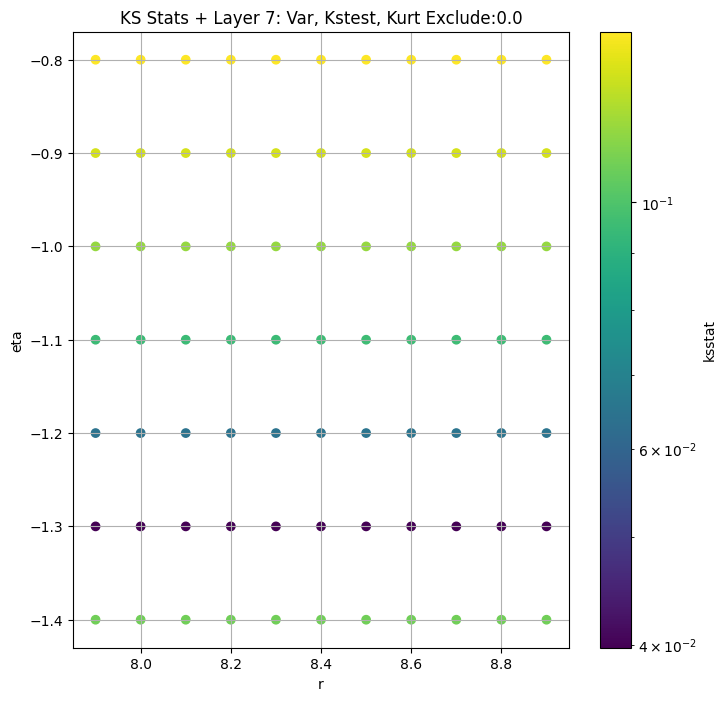

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.07266999999999979 2.2125123


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.07266999999999979 2.1275153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.07266999999999979 2.06495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.07266999999999979 2.0111547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.07266999999999979 1.9630419


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.07266999999999979 1.8785466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.07266999999999979 1.8052689


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.07266999999999979 1.7400512


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.07266999999999979 1.6810476


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.07266999999999979 1.6270866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.07266999999999979 1.4878695
Number of samples: 100000, Without approximation : 28966912


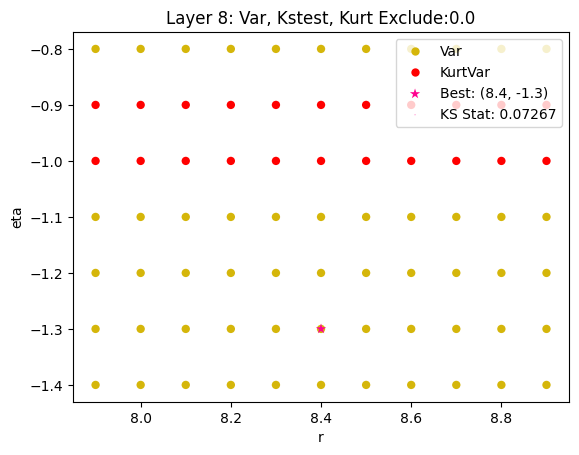

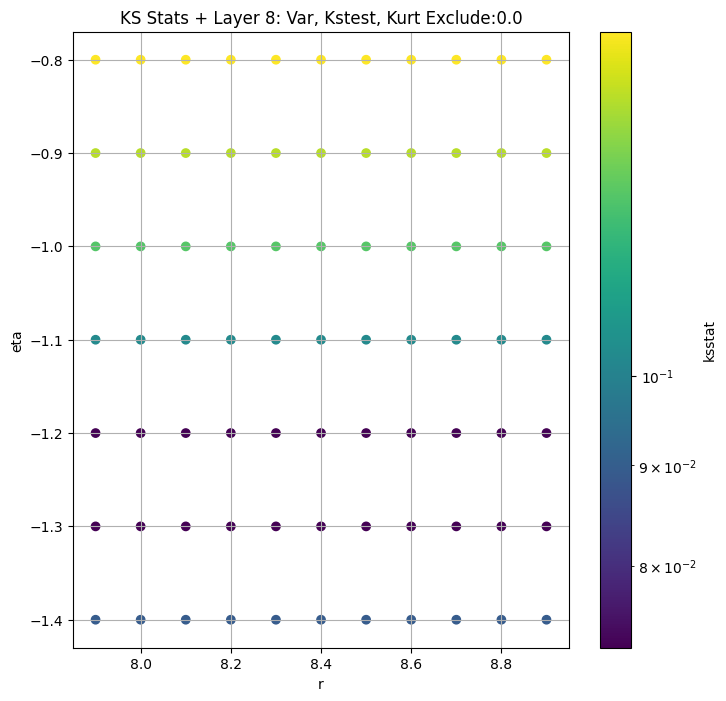

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.11159999999999981 0.53296876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.11159999999999981 0.5102359


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.11159999999999981 0.49366406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.11159999999999981 0.47954965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.11159999999999981 0.4670261


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.11159999999999981 0.44526502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.11159999999999981 0.426575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.11159999999999981 0.41007593


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.11159999999999981 0.39525387


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.11159999999999981 0.38177818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.11159999999999981 0.3473453
Number of samples: 100000, Without approximation : 115867648


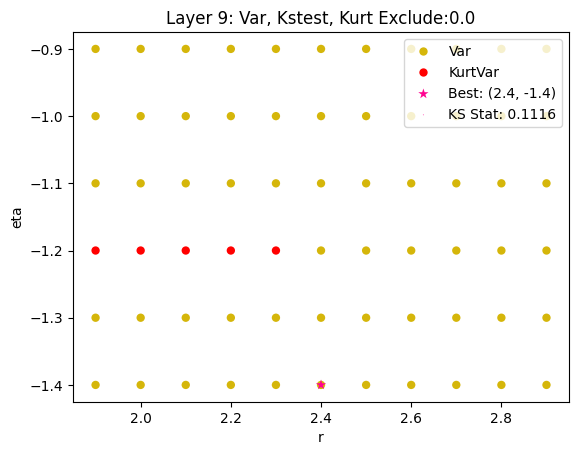

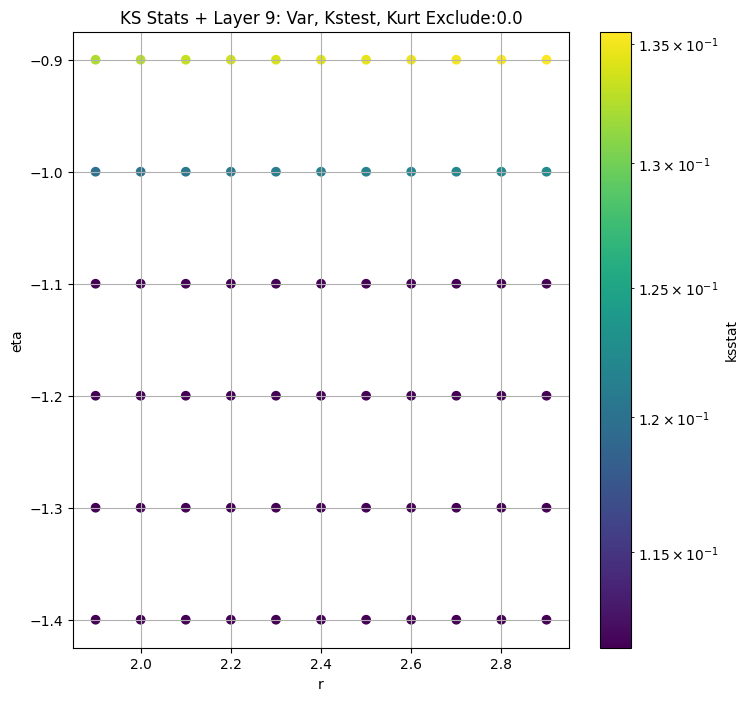

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.15419999999999978 0.14421217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.15419999999999978 0.13754581


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.15419999999999978 0.13260333


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.15419999999999978 0.12842925


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.15419999999999978 0.124761924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.15419999999999978 0.11847065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.15419999999999978 0.113153756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.15419999999999978 0.10852825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.15419999999999978 0.10442489


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.15419999999999978 0.100733265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.15419999999999978 0.09146108
Number of samples: 100000, Without approximation : 463470592


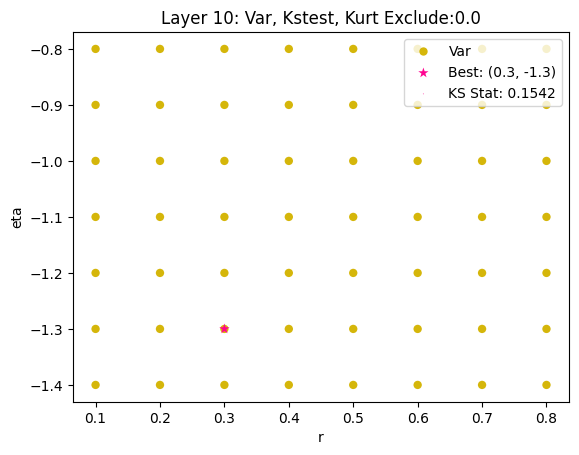

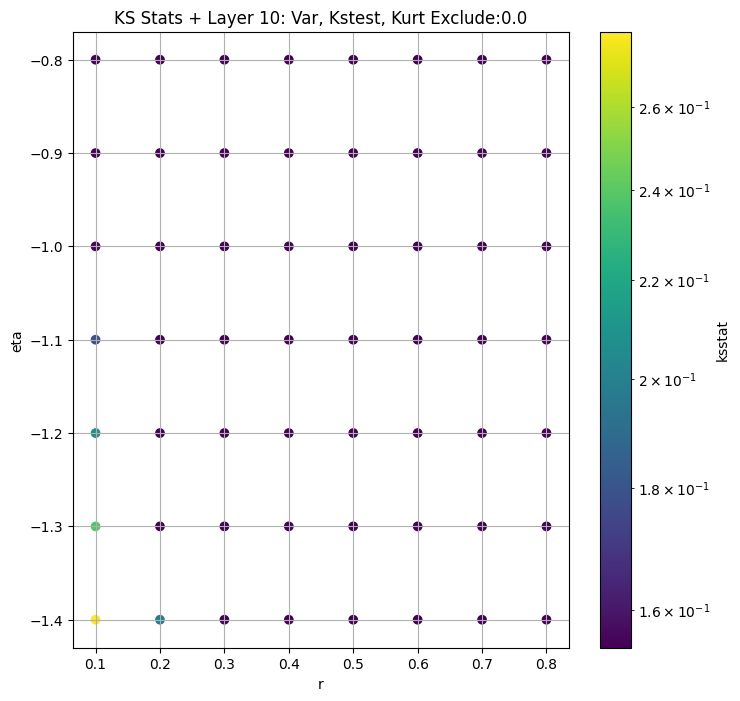

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7896.740000  7319.860000  8503.691000   4.029505    3.282084   
3      2191.322500  2039.346900  2350.041300   5.528359    4.460040   
4       643.439800   592.870900   696.672000   7.709305    6.309804   
5       168.817800   154.845860   183.616710   9.205141    7.572452   
6        41.613914    37.854664    45.583233  11.000242    9.139973   
7         9.721992     8.789999    10.716441  12.992339   10.829866   
8         2.212512     1.985581     2.454784  14.952187   12.354908   
9         0.532969     0.475431     0.594252  16.883390   13.778850   
10        0.144212     0.128029     0.161782  18.381569   14.742287   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.816091           7072             0.009867        0.7         -0.5   
3        6.719029          28288             0.004510        1.1         -1.0   
4        9.355474         113152             0.004210        0.9         -1.1   
5       11.239720         452608             0.007199        1.3         -1.2   
6       13.232309        1810432             0.017387        0.6         -1.2   
7       15.625156        7241728             0.039740        8.4         -1.3   
8       18.134668       28966912             0.072670        8.4         -1.3   
9       20.649199      115867648             0.111600        2.4         -1.4   
10      22.425297      463470592             0.154200        0.3         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        3975.180673                     0.0         7896.740000   
3        4797.982100                     0.0         2191.322500   
4        1350.625244                    75.0          602.688050   
5         558.016010                   250.0          141.418750   
6          54.375882                   300.0           33.204334   
7          61.535149                     0.0            9.721992   
8          14.004052                     0.0            2.212512   
9           6.471661                     0.0            0.532969   
10          0.032547                     0.0            0.144212   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.026489947430582306, var: 5256.560546875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.02072960793230727, var: 5650.15087890625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.016361766862595828, var: 6136.3876953125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.011459144611127847, var: 6787.275390625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.009867179124547404, var: 7896.740234375
Number of samples: 7072, Without approximation : 7072


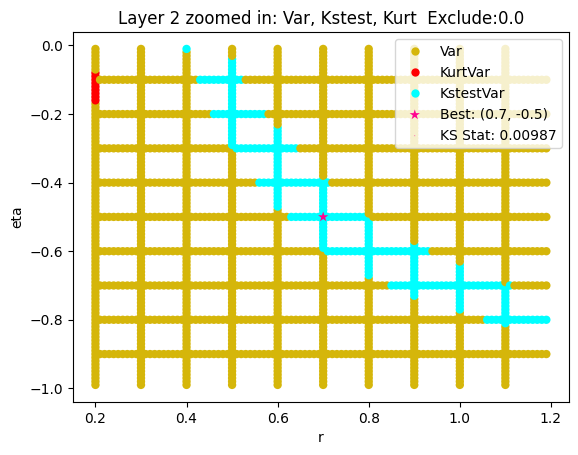

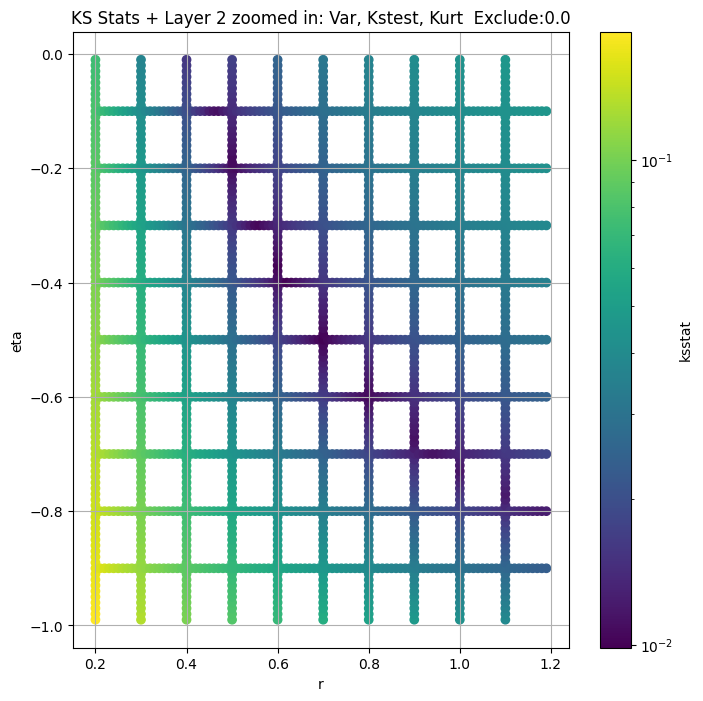

Layer 3


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.008392014759821764, var: 1838.977783203125


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.006945270620000277, var: 1899.3656005859375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.005476532664329292, var: 1968.64111328125


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.00441204318149796, var: 2053.99658203125


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.004510372556250641, var: 2191.322509765625
Number of samples: 28288, Without approximation : 28288


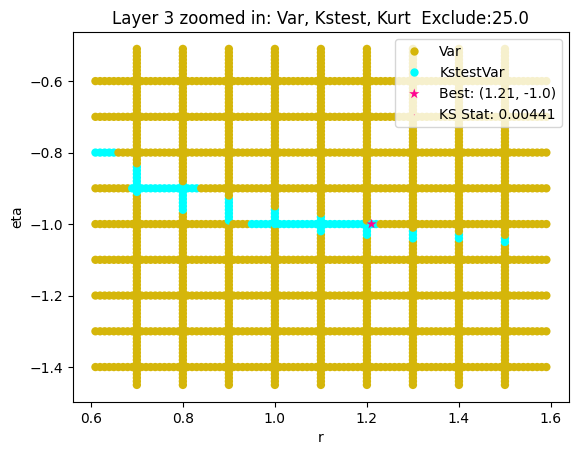

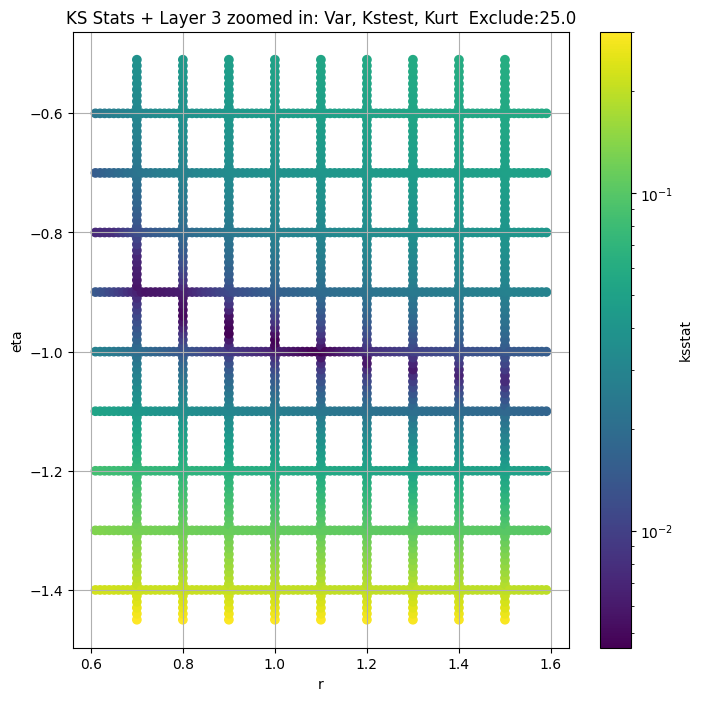

Layer 4


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + 100 = 175, ksstat: 0.00538164540209719, var: 567.612060546875


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + 75 = 150, ksstat: 0.005159844300494432, var: 575.4965209960938


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + 50 = 125, ksstat: 0.004714020710529659, var: 583.8687133789062


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + 25 = 100, ksstat: 0.004442491553684792, var: 592.8639526367188


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + 0 = 75, ksstat: 0.004019709492323827, var: 602.6880493164062


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + -25 = 50, ksstat: 0.0038343138517714093, var: 613.61328125


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + -50 = 25, ksstat: 0.003939464376179813, var: 626.1707763671875


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 4, 75.0 + -75 = 0, ksstat: 0.00424062391461294, var: 643.4398193359375
Number of samples: 100000, Without approximation : 113152


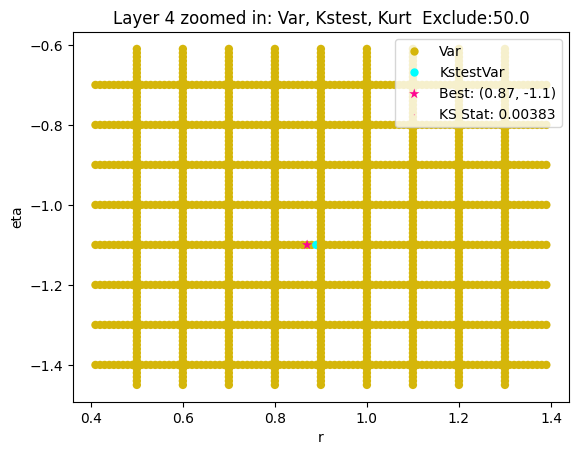

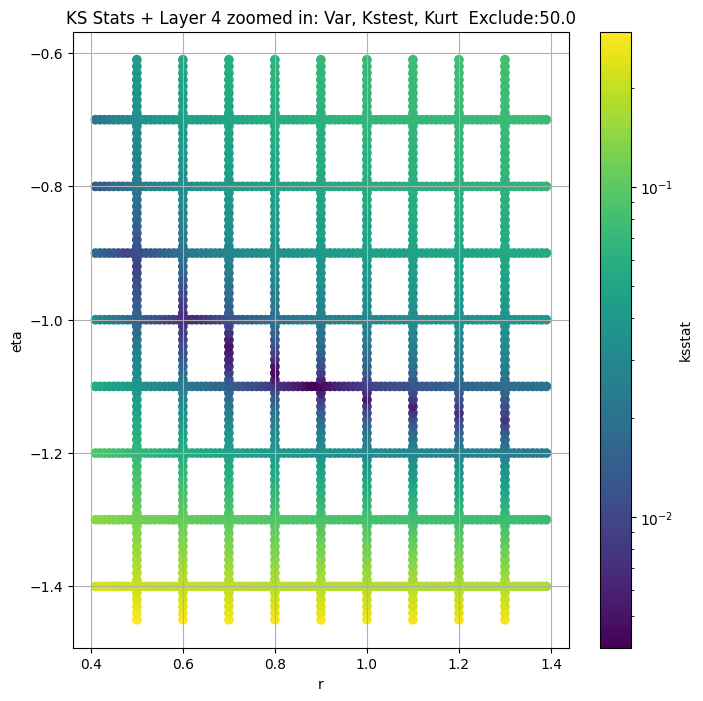

Layer 5


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + 100 = 350, ksstat: 0.007172624611304523, var: 134.64791870117188


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + 75 = 325, ksstat: 0.006887533065476403, var: 136.2447509765625


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + 50 = 300, ksstat: 0.006952706452397872, var: 137.90220642089844


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + 25 = 275, ksstat: 0.007020259414798641, var: 139.62574768066406


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + 0 = 250, ksstat: 0.007087783492082278, var: 141.4187469482422


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + -25 = 225, ksstat: 0.007131549355055722, var: 143.29244995117188


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + -50 = 200, ksstat: 0.007208278312093197, var: 145.26043701171875


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + -75 = 175, ksstat: 0.007223790653096751, var: 147.3382110595703


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 250.0 + -100 = 150, ksstat: 0.007152827026939312, var: 149.5451202392578
Number of samples: 100000, Without approximation : 452608


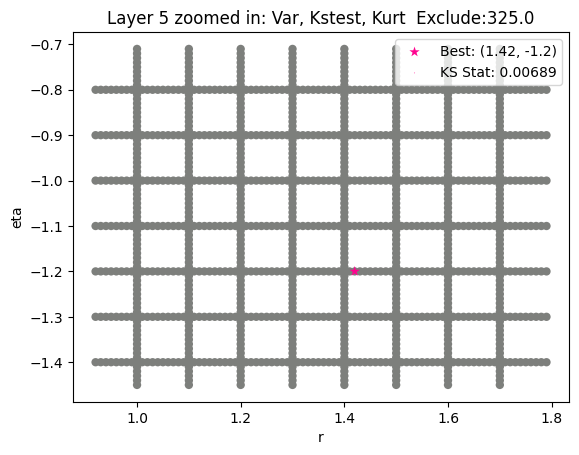

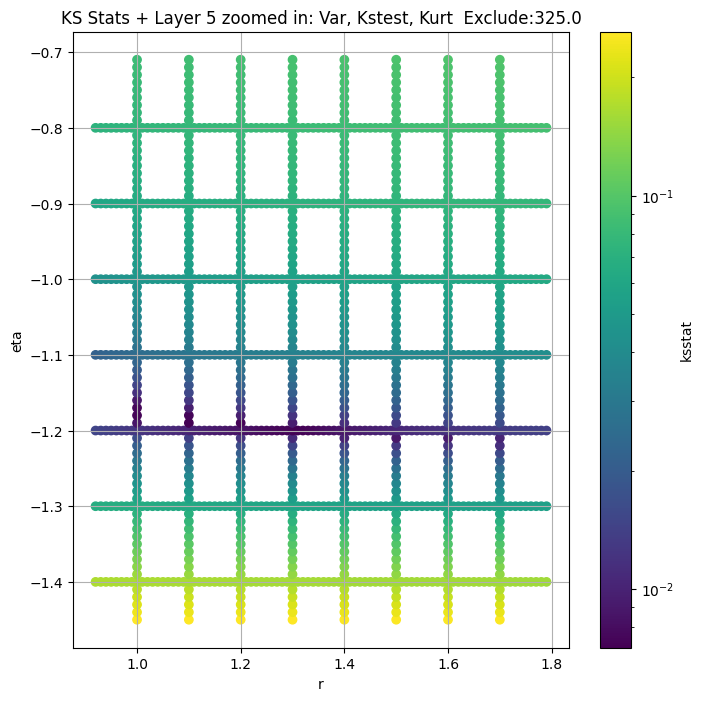

Layer 6


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + 100 = 400, ksstat: 0.016780000000000128, var: 31.50197410583496


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + 75 = 375, ksstat: 0.016780000000000128, var: 31.90460968017578


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + 50 = 350, ksstat: 0.016780000000000128, var: 32.32172393798828


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + 25 = 325, ksstat: 0.016780000000000128, var: 32.75420379638672


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + 0 = 300, ksstat: 0.016780000000000128, var: 33.2043342590332


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + -25 = 275, ksstat: 0.016780000000000128, var: 33.67282485961914


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + -50 = 250, ksstat: 0.016780000000000128, var: 34.16202163696289


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + -75 = 225, ksstat: 0.016780000000000128, var: 34.67428970336914


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 300.0 + -100 = 200, ksstat: 0.016780000000000128, var: 35.21255874633789
Number of samples: 100000, Without approximation : 1810432


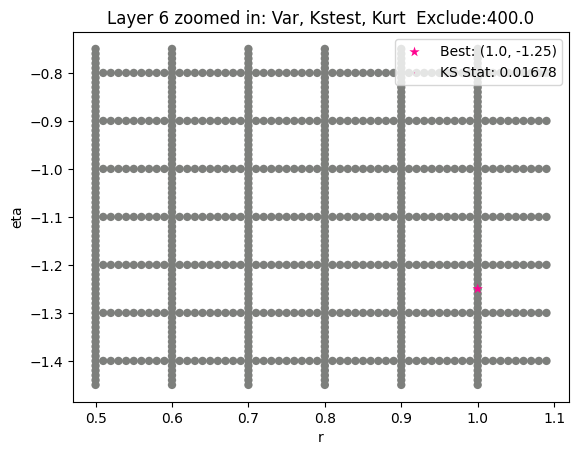

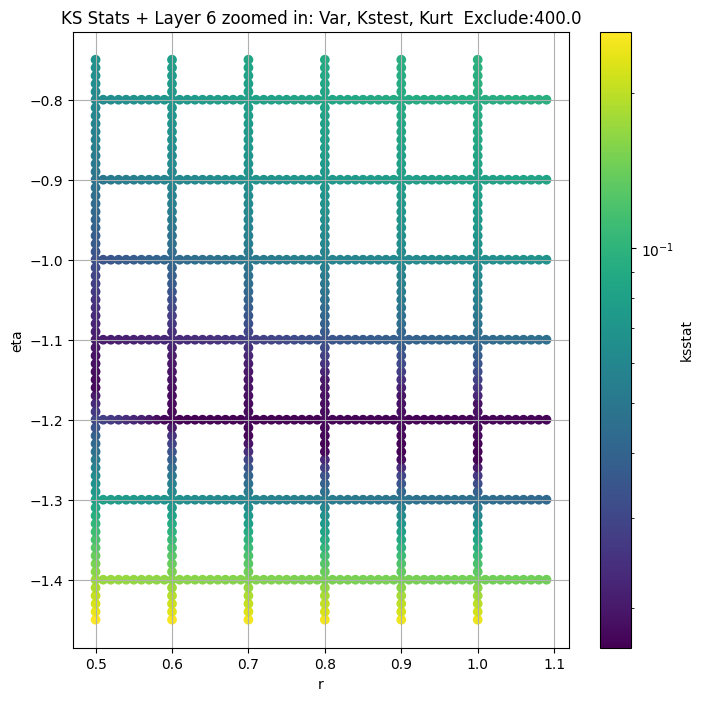

Layer 7


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.039739999999999776, var: 8.72446060180664


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.039739999999999776, var: 8.918615341186523


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.039739999999999776, var: 9.134138107299805


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.039739999999999776, var: 9.38415241241455


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.039739999999999776, var: 9.721991539001465
Number of samples: 100000, Without approximation : 7241728


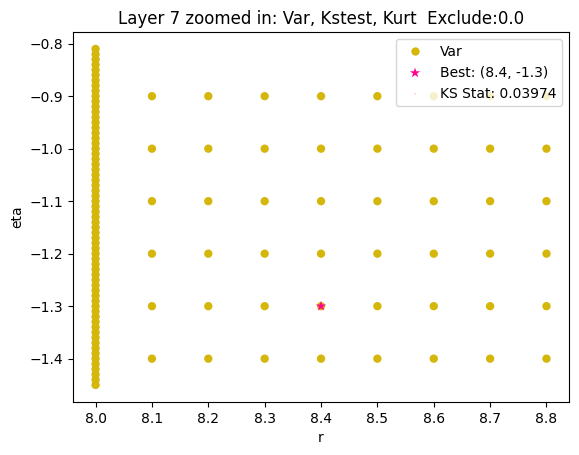

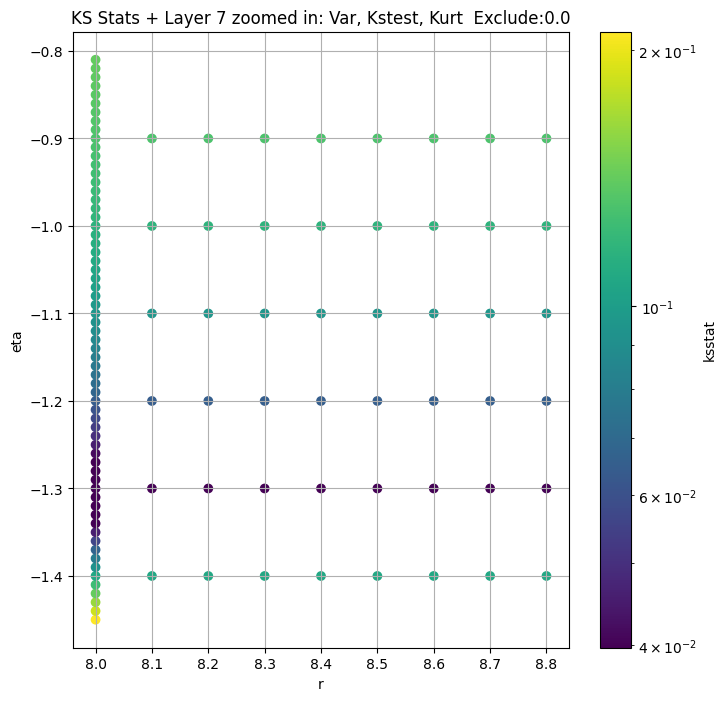

Layer 8


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.07266999999999979, var: 1.96304190158844


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.07266999999999979, var: 2.0111546516418457


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.07266999999999979, var: 2.0649499893188477


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.07266999999999979, var: 2.1275153160095215


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.07266999999999979, var: 2.212512254714966
Number of samples: 100000, Without approximation : 28966912


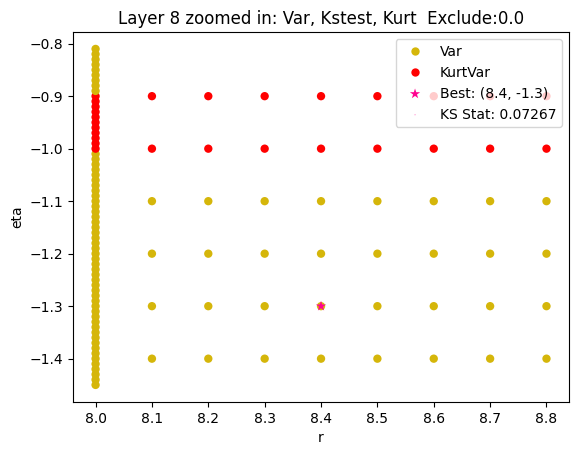

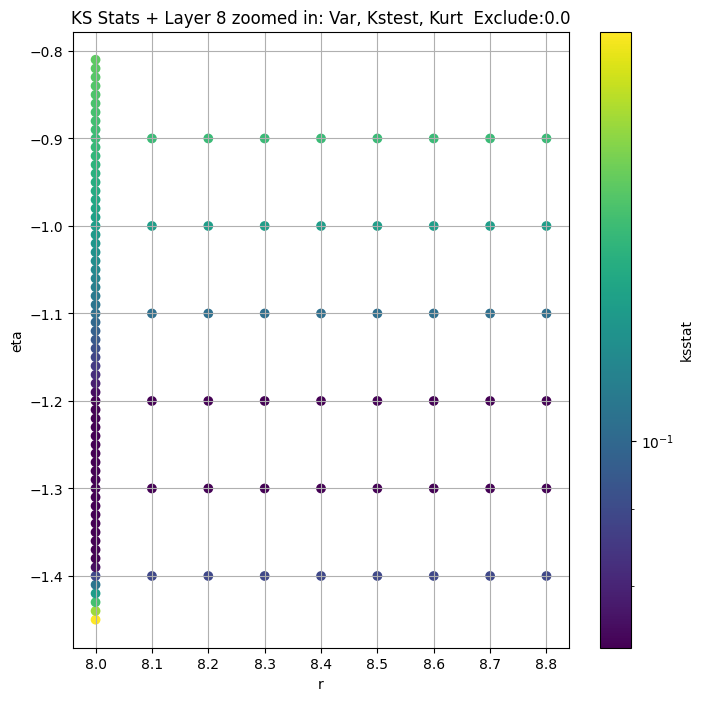

Layer 9


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.11159999999999981, var: 0.46702611446380615


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.11159999999999981, var: 0.4795496463775635


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.11159999999999981, var: 0.49366405606269836


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.11159999999999981, var: 0.5102359056472778


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.11159999999999981, var: 0.5329687595367432
Number of samples: 100000, Without approximation : 115867648


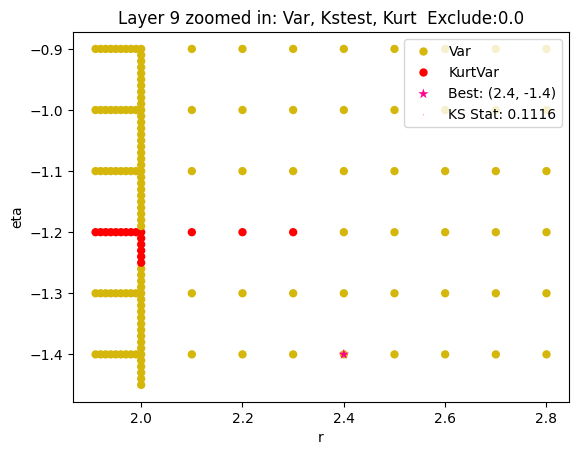

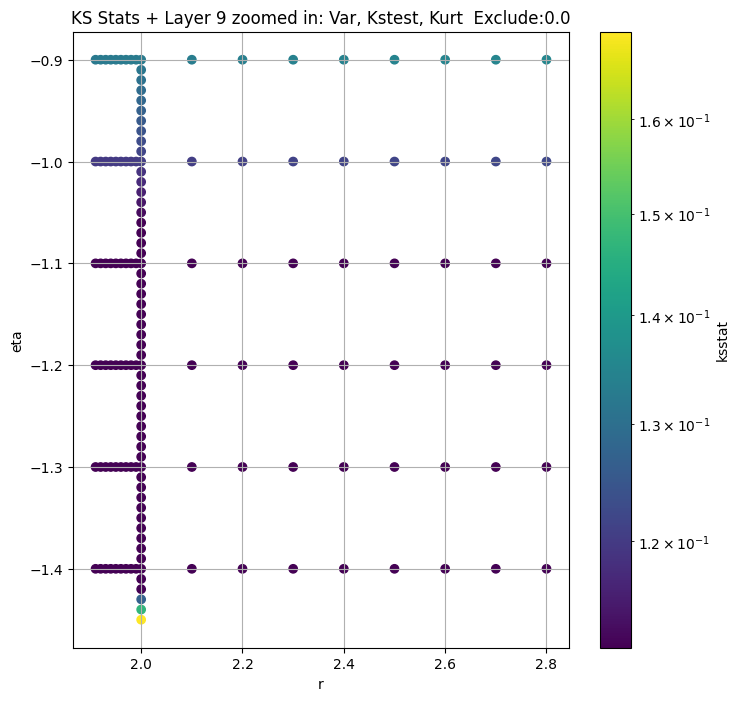

Layer 10


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 10, 0.0 + 100 = 100, ksstat: 0.15419999999999978, var: 0.1247619241476059


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 10, 0.0 + 75 = 75, ksstat: 0.15419999999999978, var: 0.12842924892902374


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 10, 0.0 + 50 = 50, ksstat: 0.15419999999999978, var: 0.13260333240032196


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 10, 0.0 + 25 = 25, ksstat: 0.15419999999999978, var: 0.13754580914974213


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 10, 0.0 + 0 = 0, ksstat: 0.15419999999999978, var: 0.14421217143535614
Number of samples: 100000, Without approximation : 463470592


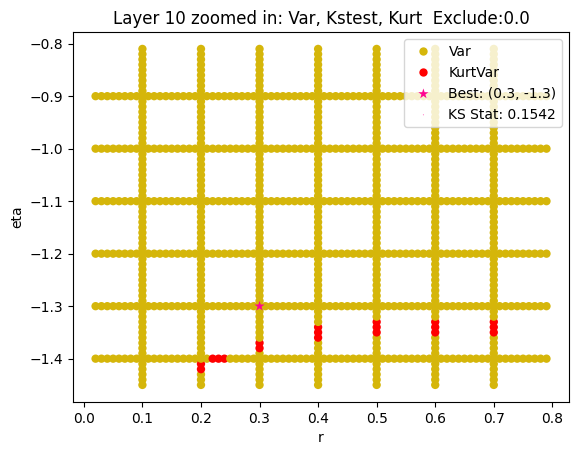

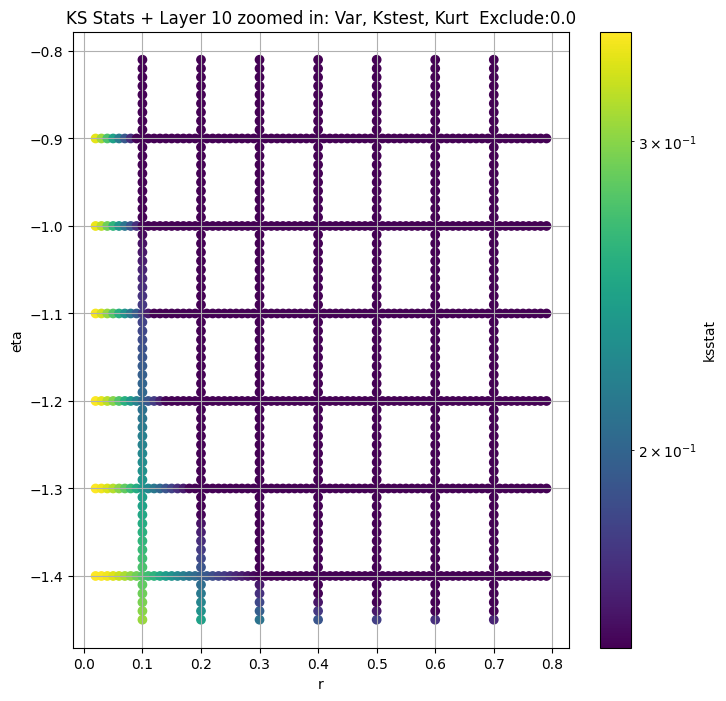

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7896.740000  7319.860000  8503.691000   4.029505    3.282084   
3      2191.322500  2039.346900  2350.041300   5.528359    4.460040   
4       643.439800   592.870900   696.672000   7.709305    6.309804   
5       168.817800   154.845860   183.616710   9.205141    7.572452   
6        41.613914    37.854664    45.583233  11.000242    9.139973   
7         9.721992     8.789999    10.716441  12.992339   10.829866   
8         2.212512     1.985581     2.454784  14.952187   12.354908   
9         0.532969     0.475431     0.594252  16.883390   13.778850   
10        0.144212     0.128029     0.161782  18.381569   14.742287   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.816091           7072             0.009867        0.7         -0.5   
3        6.719029          28288             0.004510        1.1         -1.0   
4        9.355474         113152             0.004210        0.9         -1.1   
5       11.239720         452608             0.007199        1.3         -1.2   
6       13.232309        1810432             0.017387        0.6         -1.2   
7       15.625156        7241728             0.039740        8.4         -1.3   
8       18.134668       28966912             0.072670        8.4         -1.3   
9       20.649199      115867648             0.111600        2.4         -1.4   
10      22.425297      463470592             0.154200        0.3         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        3975.180673                     0.0         7896.740000   
3        4797.982100                     0.0         2053.996582   
4        1350.625244                    75.0          613.613281   
5         558.016010                   250.0          136.244751   
6          54.375882                   300.0           31.501974   
7          61.535149                     0.0            9.721992   
8          14.004052                     0.0            2.212512   
9           6.471661                     0.0            0.532969   
10          0.032547                     0.0            0.144212   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.016126          0.009867    0.70     -0.50   
3                     0.008069          0.004412    1.21     -1.00   
4                     0.004036          0.003834    0.87     -1.10   
5                     0.002018          0.006888    1.42     -1.20   
6                     0.001009          0.016780    1.00     -1.25   
7                     0.000505          0.039740    8.40     -1.30   
8                     0.000252          0.072670    8.40     -1.30   
9                     0.000126          0.111600    2.40     -1.40   
10                    0.000063          0.154200    0.30     -1.30   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      3975.180673                  0.0        19111  
3      4850.479739                 25.0        95472  
4      1321.212896                 50.0       127296  
5       558.705693                325.0        40276  
6       126.007896                400.0         6712  
7        61.535149                  0.0         1117  
8        14.004052                  0.0          331  
9         6.471661                  0.0          138  
10        0.032547                  0.0           75

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

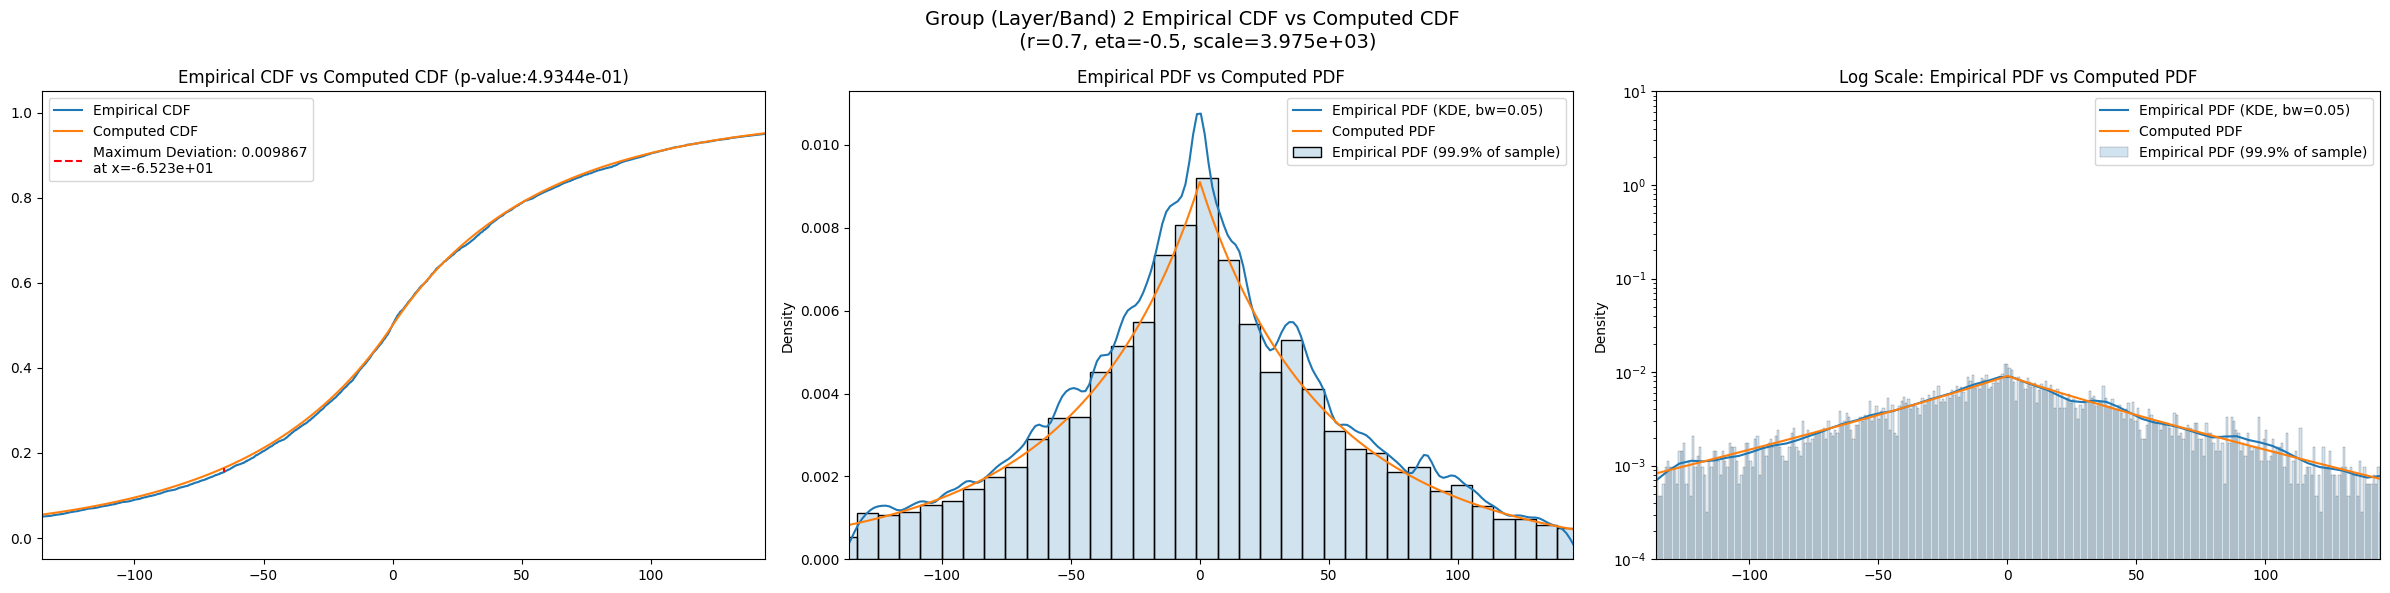

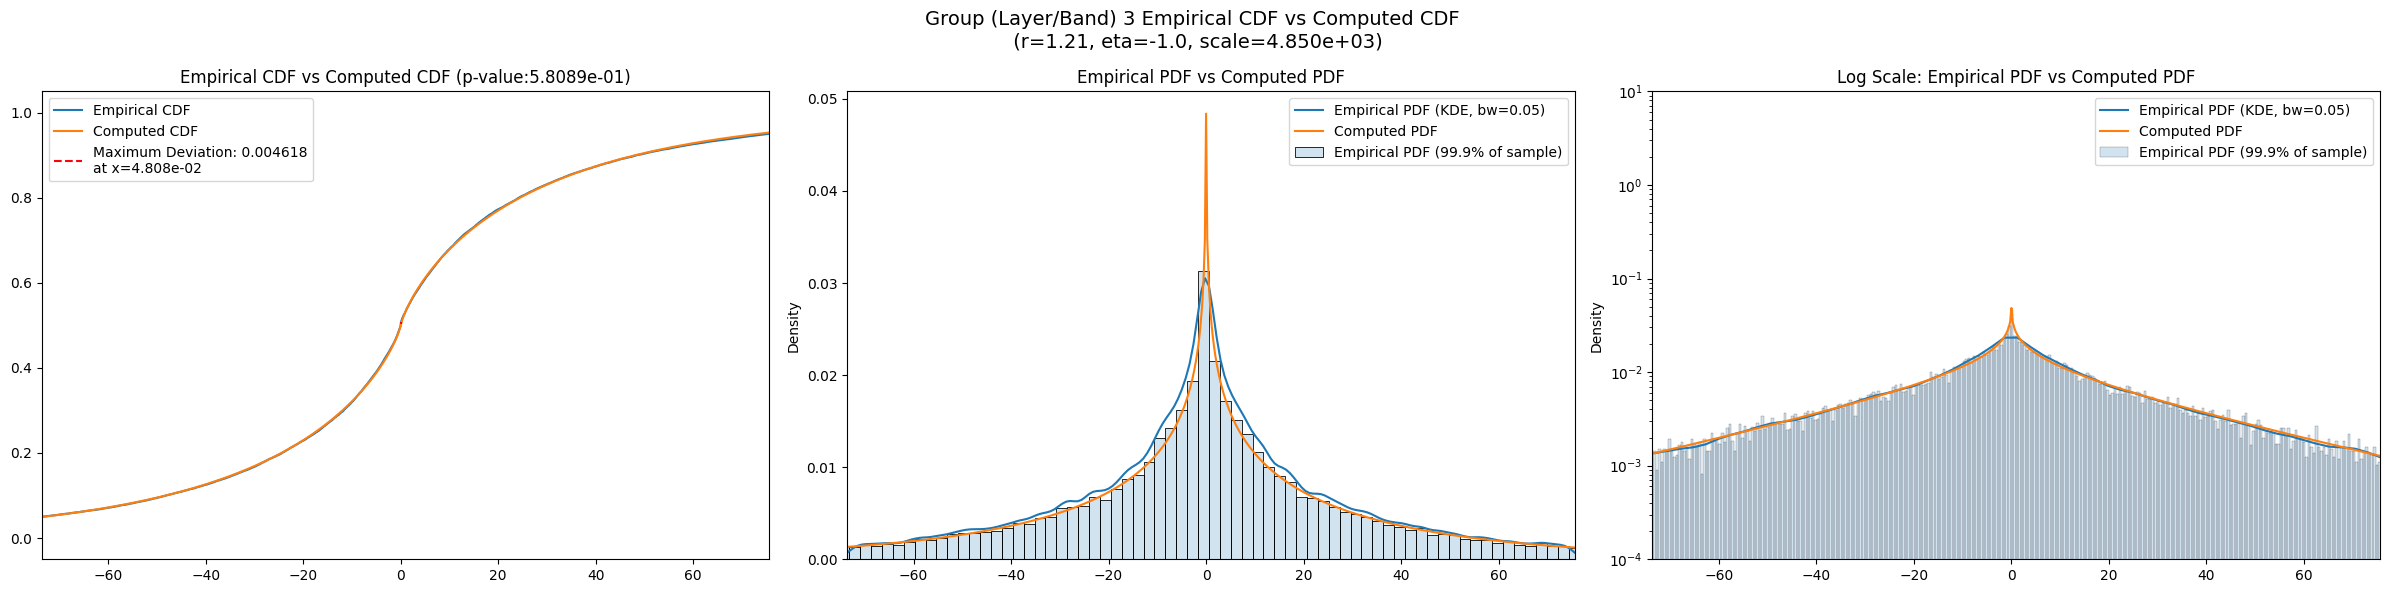

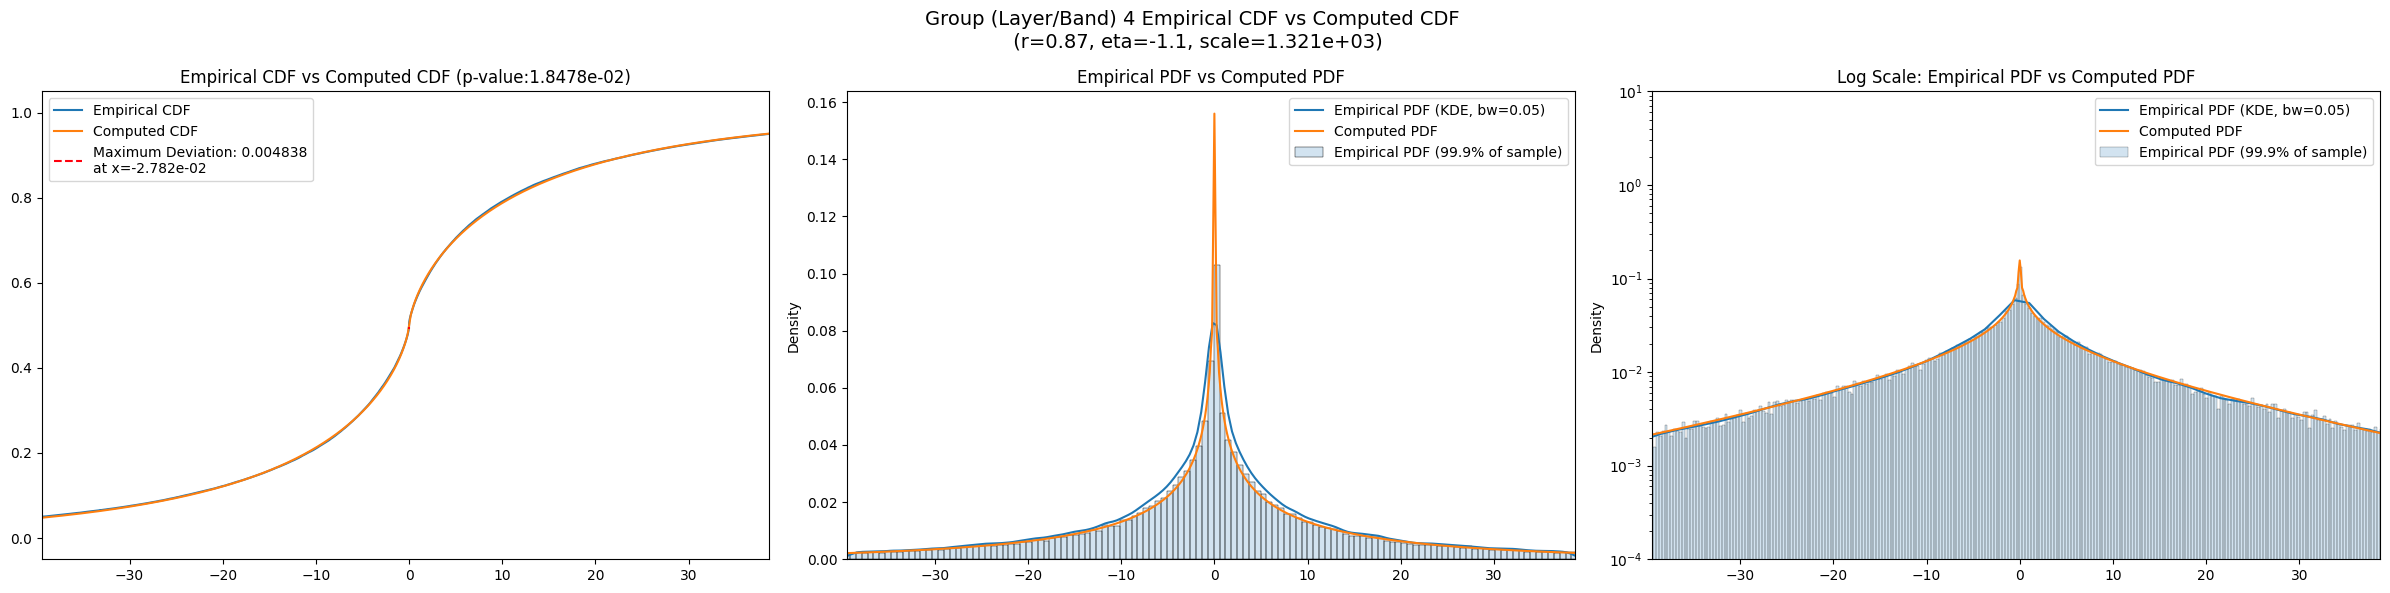

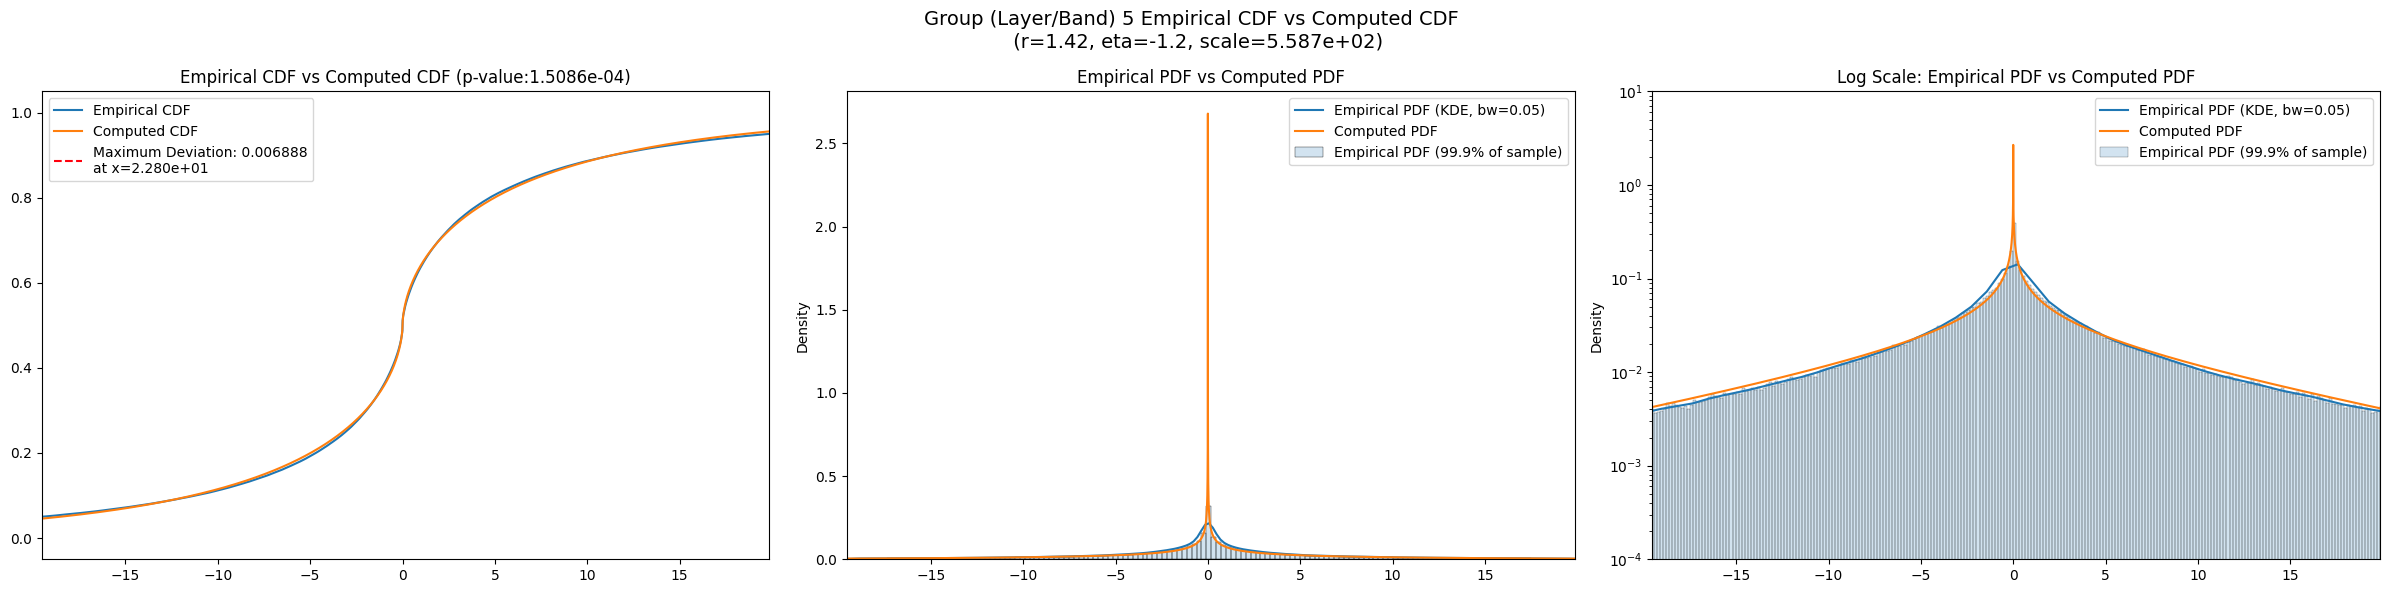

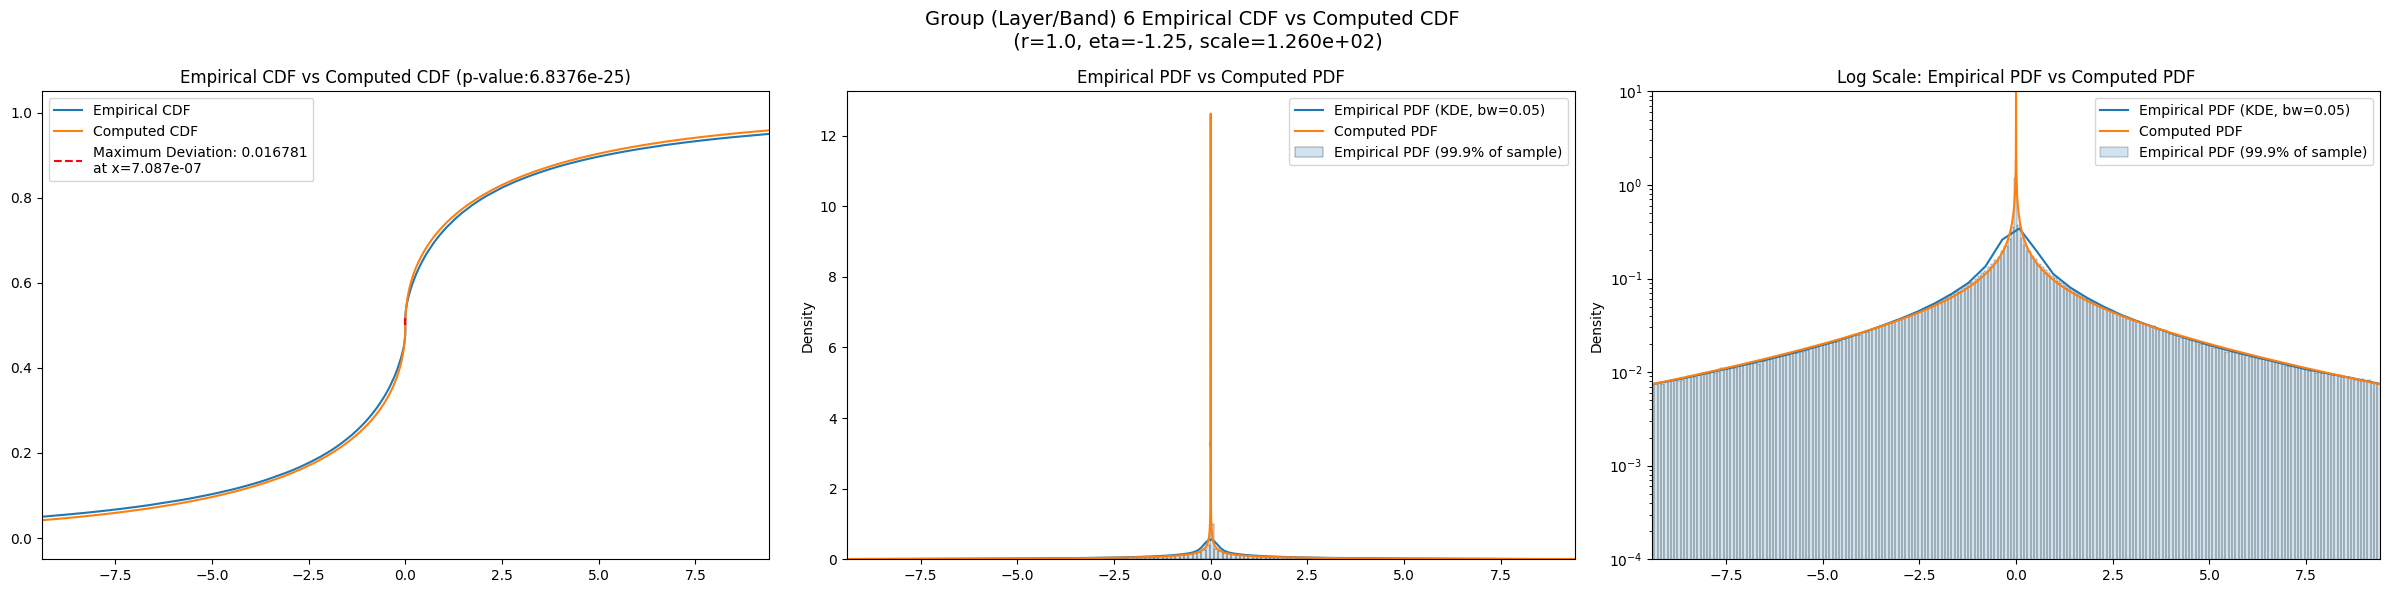

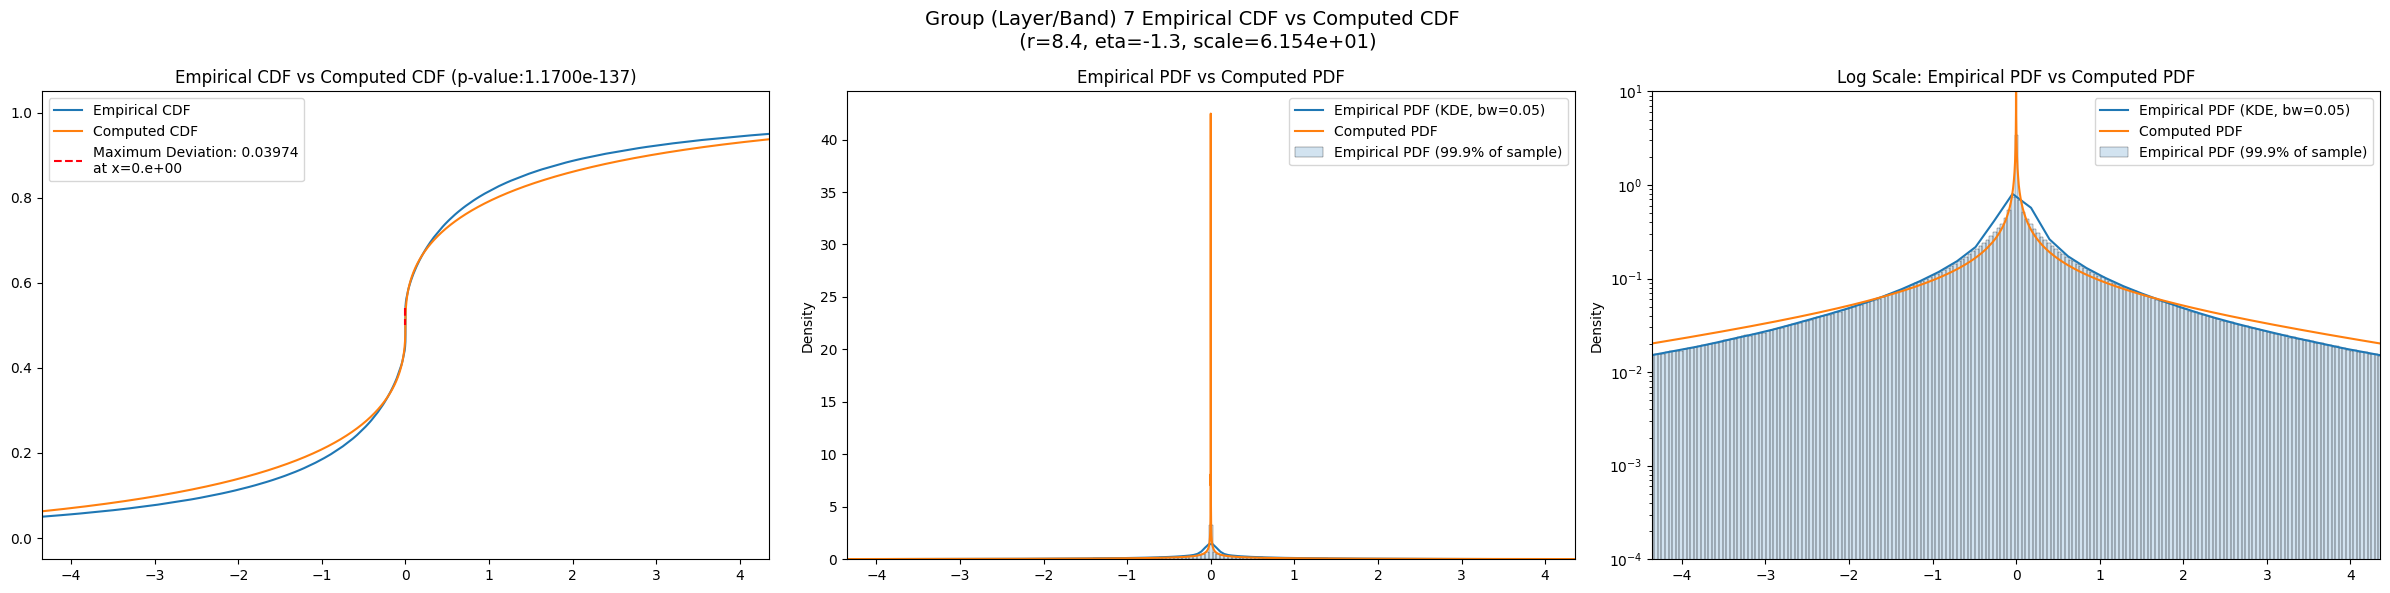

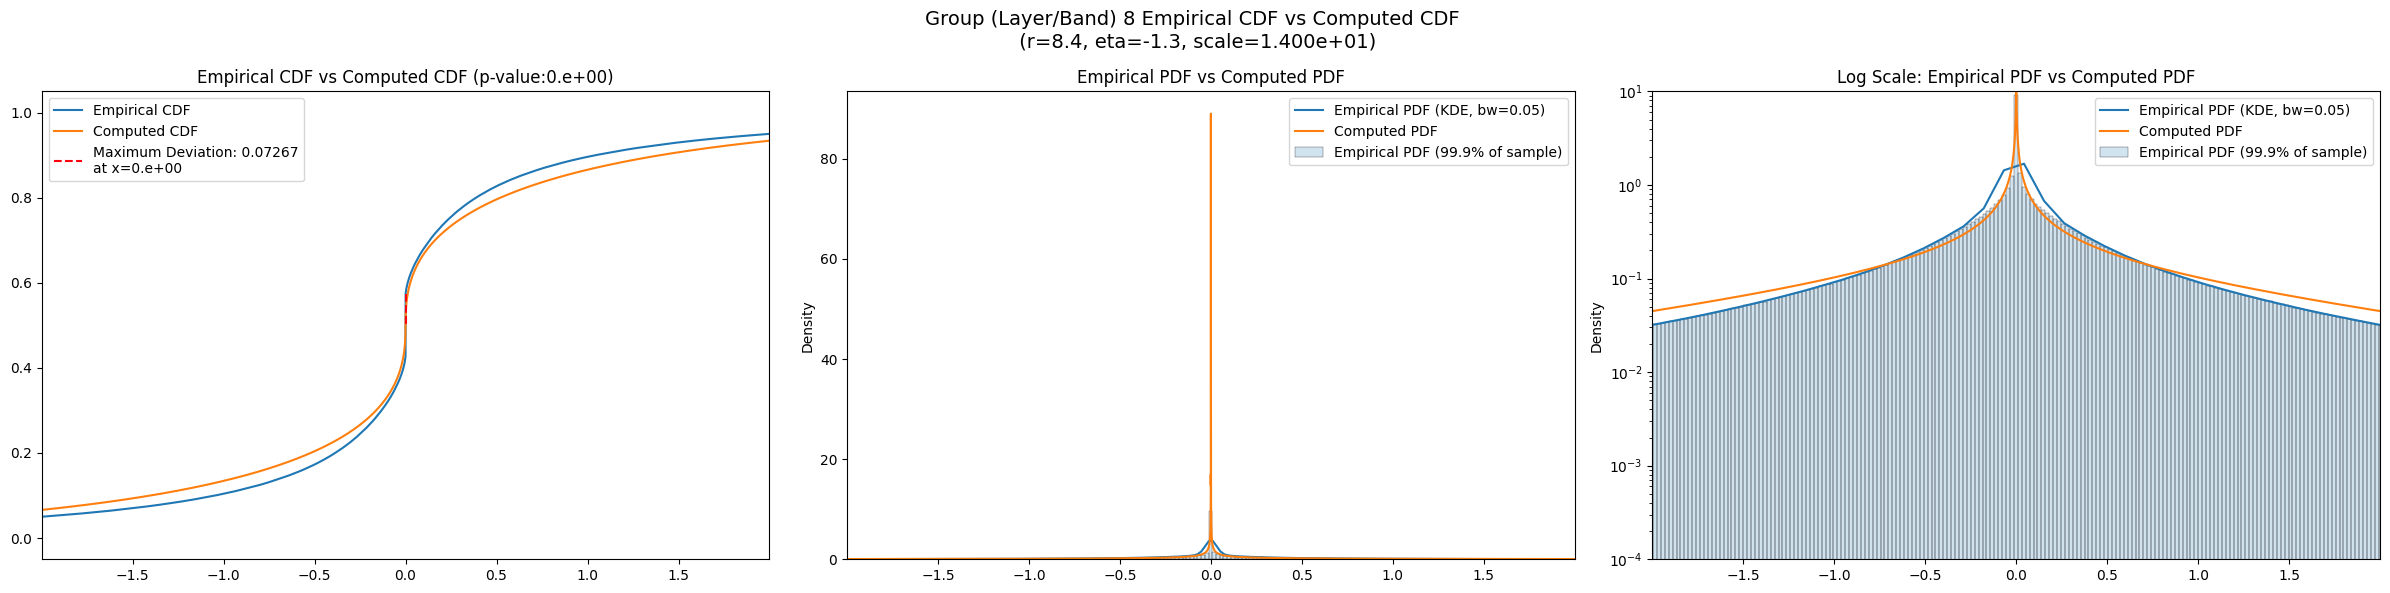

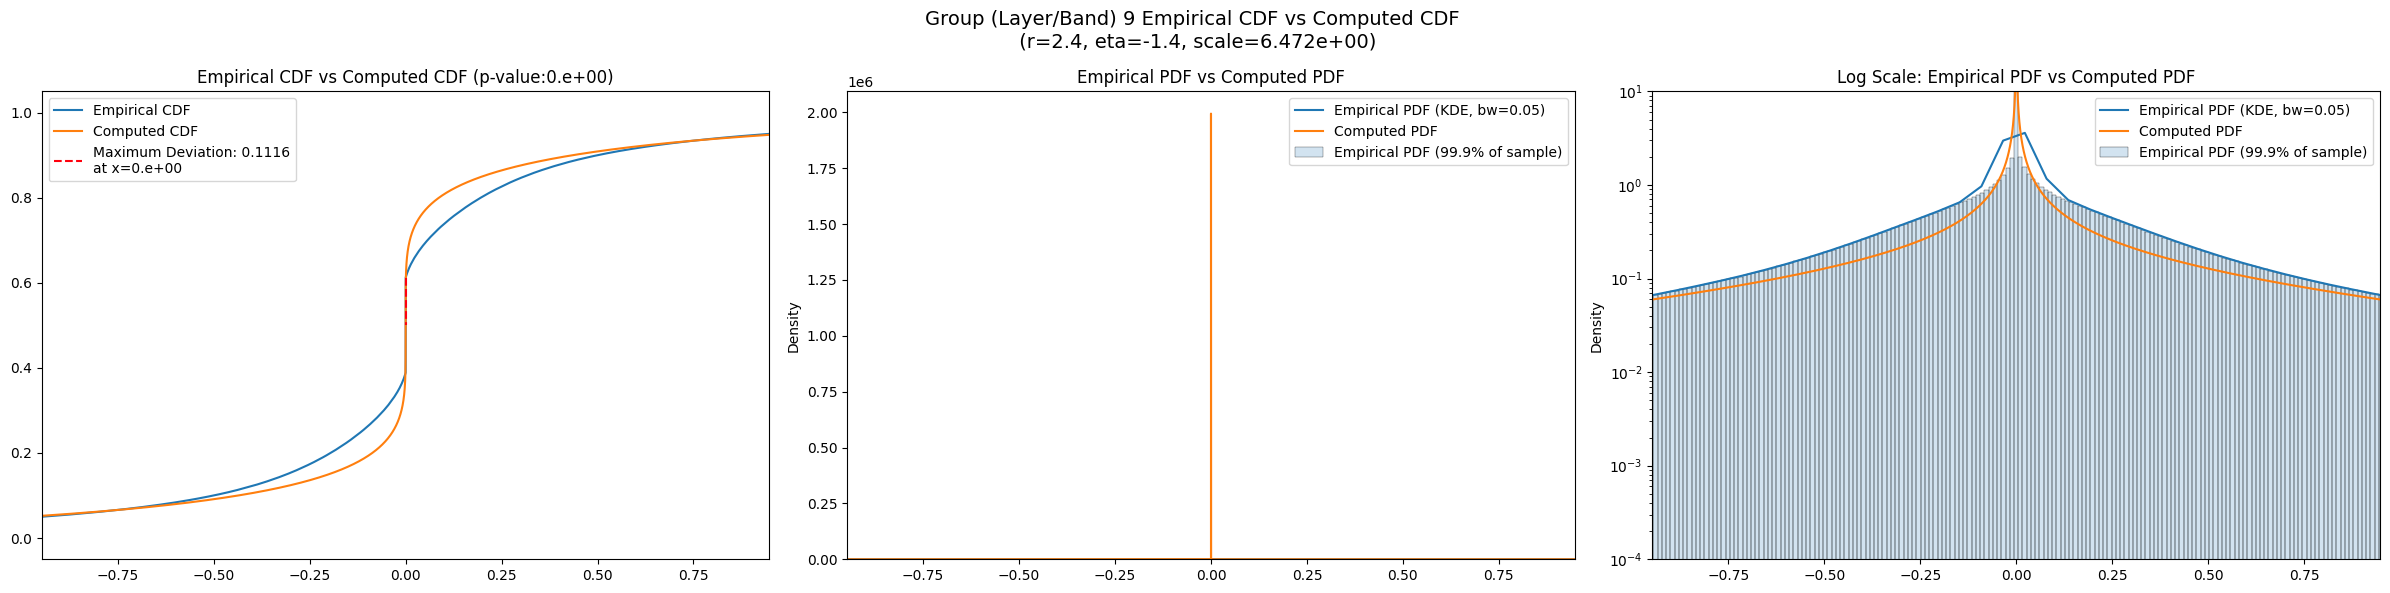

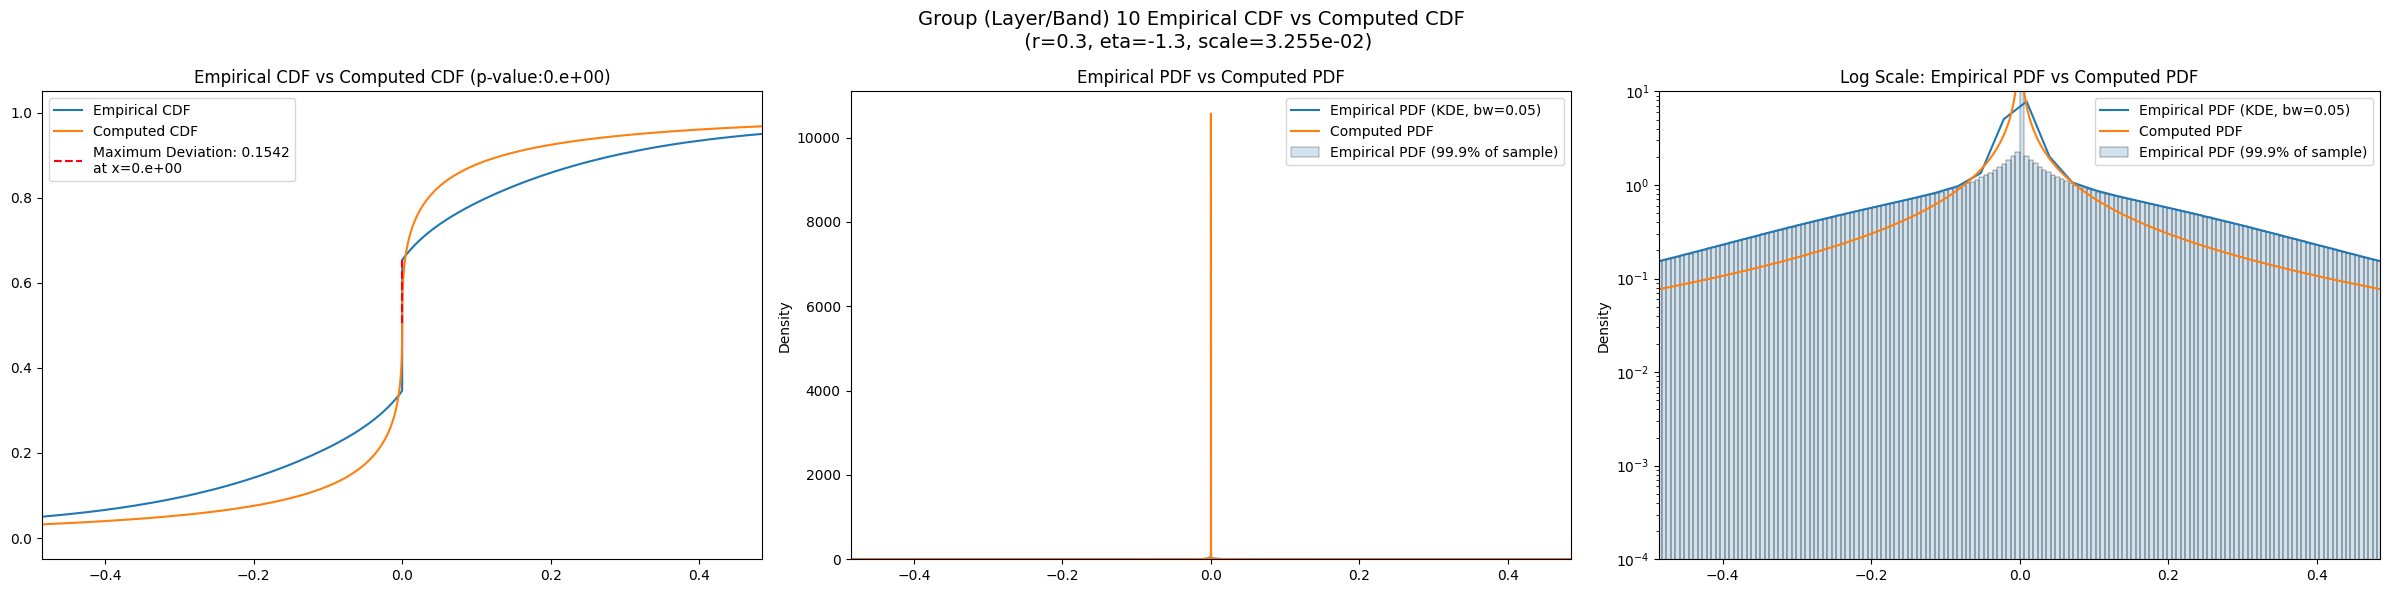

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7896.740000  7319.860000  8503.691000   4.029505    3.282084   
3      2191.322500  2039.346900  2350.041300   5.528359    4.460040   
4       643.439800   592.870900   696.672000   7.709305    6.309804   
5       168.817800   154.845860   183.616710   9.205141    7.572452   
6        41.613914    37.854664    45.583233  11.000242    9.139973   
7         9.721992     8.789999    10.716441  12.992339   10.829866   
8         2.212512     1.985581     2.454784  14.952187   12.354908   
9         0.532969     0.475431     0.594252  16.883390   13.778850   
10        0.144212     0.128029     0.161782  18.381569   14.742287   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.816091           7072             0.009867        0.7         -0.5   
3        6.719029          28288             0.004510        1.1         -1.0   
4        9.355474         113152             0.004210        0.9         -1.1   
5       11.239720         452608             0.007199        1.3         -1.2   
6       13.232309        1810432             0.017387        0.6         -1.2   
7       15.625156        7241728             0.039740        8.4         -1.3   
8       18.134668       28966912             0.072670        8.4         -1.3   
9       20.649199      115867648             0.111600        2.4         -1.4   
10      22.425297      463470592             0.154200        0.3         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       65.715300              0.038325          1.839510e-09   
3      ...       30.280000              0.051287          4.169190e-65   
4      ...       13.538700              0.063817          0.000000e+00   
5      ...        5.931780              0.073743          0.000000e+00   
6      ...        2.498370              0.081345          0.000000e+00   
7      ...        1.037030              0.088030          0.000000e+00   
8      ...        0.426612              0.096680          0.000000e+00   
9      ...        0.174951              0.114244          0.000000e+00   
10     ...        0.078424              0.154200          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          58.113900             0.012671         2.045140e-01  48.148000   
3          26.421600             0.023776         2.530670e-14  21.207500   
4          11.658200             0.037638        1.034200e-139   9.265800   
5           5.065160             0.049004         0.000000e+00   3.944570   
6           2.106810             0.058045         0.000000e+00   1.624800   
7           0.848325             0.067668         0.000000e+00   0.651767   
8           0.326182             0.082614         0.000000e+00   0.252775   
9           0.121554             0.111603         0.000000e+00   0.097866   
10          0.098708             0.154200         0.000000e+00   0.068183   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.018745   1.371490e-02          4.934424e-01  
3           0.027478   5.477000e-19          6.388740e-01  
4           0.040658  5.743330e-163          7.160630e-02  
5           0.050848   0.000000e+00          4.461579e-19  
6           0.059749   0.000000e+00          0.000000e+00  
7           0.069430   0.000000e+00          0.000000e+00  
8           0.084158   0.000000e+00          0.000000e+00  
9           0.111603   0.000000e+00          0.000000e+00  
10          0.154200   0.000000e+00          0.000000e+00  

[9 rows x 30 

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.009867                 0.016126          0.009867   
3                 0.004510                 0.008069          0.004412   
4                 0.004210                 0.004036          0.003834   
5                 0.007199                 0.002018          0.006888   
6                 0.017387                 0.001009          0.016780   
7                 0.039740                 0.000505          0.039740   
8                 0.072670                 0.000252          0.072670   
9                 0.111600                 0.000126          0.111600   
10                0.154200                 0.000063          0.154200   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.038325             0.012671       0.018745  
3                  0.051287             0.023776       0.027478  
4                  0.063817             0.037638       0.040658  
5                  0.073743             0.049004       0.050848  
6                  0.081345             0.058045       0.059749  
7                  0.088030             0.067668       0.069430  
8                  0.096680             0.082614       0.084158  
9                  0.114244             0.111603       0.111603  
10                 0.154200             0.154200       0.154200

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             7896.740000          0.009867    0.70     -0.50  3975.180673   
3             2053.996582          0.004412    1.21     -1.00  4850.479739   
4              613.613281          0.003834    0.87     -1.10  1321.212896   
5              136.244751          0.006888    1.42     -1.20   558.705693   
6               31.501974          0.016780    1.00     -1.25   126.007896   
7                9.721992          0.039740    8.40     -1.30    61.535149   
8                2.212512          0.072670    8.40     -1.30    14.004052   
9                0.532969          0.111600    2.40     -1.40     6.471661   
10               0.144212          0.154200    0.30     -1.30     0.032547   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                     25.0  
4                     50.0  
5                    325.0  
6                    400.0  
7                      0.0  
8                      0.0  
9                      0.0  
10                     0.0

In [21]:
eng.quit()